In [1]:
using DrWatson
@quickactivate "BNP2"
using Random, ProgressMeter, WeightsAndBiasLogger, MLDataUtils, BSON, Flux, Zygote
using MLToolkit.Neural, MLToolkit.DistributionsX
using Flux: Optimise
using Revise, BNP2

In [134]:
args = (
    dt          = 1f-1,
    n_trajs     = 10,
    is_noisyobs = false,
    σ_obs       = 1f-1,
)

;

In [306]:
function sim_traj(ms, qs, ps, dt, T)
    env = Space(Particle.(ms, qs, ps))
    traj = simulate(env, DiffEqSimulator(dt), T)
    return [env, traj...]
end

function sim_data(rng; T=50, n_initials=100, n_directions=100, n_speed=100, n_moving=100, n_tests_per=10)
    ms = fill(5e10, 3)
    qs = [[-1, 0], [1, 0], [0, √3]]
    ps = [[cos(π/3), -sin(π/3)], [cos(π/3),  sin(π/3)], [cos(π),  sin(π)]]
    
    trajs, trajs_test = [], []
    # Trajectories with different initial conditions
    for i in 1:n_initials+n_tests_per
        traj = sim_traj(ms, add_gaussiannoise(rng, qs, 1f-2), add_gaussiannoise(rng, ps, 1f-2), args.dt, T)
        push!(i <= n_initials ? trajs : trajs_test, traj)
    end
    # Trajectories with different initial directions
    for i in 1:n_directions+n_tests_per
        traj = sim_traj(ms, qs, ps .* (1 + rand(rng)), args.dt, T)
        push!(i <= n_directions ? trajs : trajs_test, traj)
    end
    # Trajectories with different speed
    for i in 1:n_speed+n_tests_per
        traj = sim_traj(ms, qs, rotate.(rand(rng) * π, ps), args.dt, T)
        push!(i <= n_speed ? trajs : trajs_test, traj)
    end
    # Trajectories with different moving directions
    for i in 1:n_moving+n_tests_per
        traj = sim_traj(ms, qs, ps .+ [randn(rng, 2)], args.dt, T)
        push!(i <= n_moving ? trajs : trajs_test, traj)
    end
    
    return (trajs=trajs, trajs_test=trajs_test)
end

data_raw = sim_data(MersenneTwister(1110))

for traj in data_raw.trajs_test[1:10:end]
    HTML(animof(traj).to_html5_video()) |> display
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABG/W1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAANN2WI\nhAA3//728P4FNjuY0JcRzeidMx+/Fbi6NDe9zgAAAwAAAwAO4+Whwb68chzQAABbAAZZt/OESPzF\nAQDc9v+/3mOI2Wf50cDBv4+7P+b6IX8XAa2gVRODkz2Lim7xs86SnfIrZb1dHm0I68ORCnyjisQd\nGlV/NBmQDoDUKnmAn0779oHHW5Mmfytbg8A6RfXp2eJ0A9iuRZ15yg/HeHDEf00zni+iGUvskXTb\nSfOgOu8mjTRzJap/OV7WUNPVq5AYj3cgC1AJPEDZj1FylLORI8soDmLHq9goRoQwbVR94NJ4FbAg\nSiSIgb63Wf9NONEnfYbFlG3ADmq2T8IUzLTtFzu8dzv5wfOoSrWYRgqCwBRv58YpMP/gRcnoysts\nAj2/gHizhqiwsqDGswZjB+A7QzCADUClH4wy0tYMBO6nr5Hw8Qy8JMpXtSBt+oJRYz4adiHDqOfk\nGVr+41ml4lqoVNgwrrZKdbchtECACsjrzGobBXmSomNKHzIbzLouDDGdr2at28jn/V1TvdfPQZcA\nt6HTNZmAFu85LvJ+edBsEsCVtqXND5TDgGFBCaF+2ZLsMhCUMw5CZws9TwP9wObKmpESrBq8RXxs\nVr7SmFr2vHv+gfUMnnuHuLv6y9xaIVr1VUEW5NNxe1VIttRt44E0kud45SgBuYwrULVeNatIhpIv\nLosfOCE5QPG9fCUWlo/+nC4e8bJuZvqVPgOFcAA/jwYJcqISBYPncHE9NWZiMnAOKBjTSyns2thG\ngntz6f6xKNiPkMN96vytaBi14JzA61HYkTX1zANq5q1vYsr2JDs1ECDFUAPkQ8JeNwfg7s1bvDAA\n9gmWyVWvZg18EmQBsR46bQevPsfiHUsGZkXz5FXOhnA2CiDl8We7jk1GO9ly1YN+t0g7qvOUReja\nKFqUhCLk4lmBITMY7LAir9tEE7mQq0Nx8laV4IPta+hU8uQwzlSr7ae2F6Rf5LMFOKDXgA+K0SKV\nEqbHLiGn4/uJy/OdJkJcso4ki3MQOiLv3fySv9Ps2SEOTX2HYtPNATBHjL5Rrn7eqemVbzQV5Fl9\n6AtilK/gTJ/vUhp18DLRMOJzHQCyS46Y5HUSYdECxnBPEGg7v3rdtd7SbiHHNnAWTLny237Op3dx\nNt/OwvDnYX783WX29C8Nf9R+rbPDpzQREonO4JgiDyWsrmfHHyuTwYi1aUflGecjqVXQV83jBo8S\ntasF9SqvTbHwNHegEBE2AR3oxgDBLoZQoUrC71x1K/w7YuFXS5BXxjrD8vyM8tCIZXtCxzj8E7IO\nLhRTc5AAwo2eXLa+OWqYR2rtUjQXoGZCtt7XJyfhYoQqhGCed+FxY9uNXaQjNONBHjKBFyGGF5SZ\n4oYXit00kpYwvDLoOxDWhXtbAXK//6cHg7/bAxls1PsMW7K0Kmy4BE3qZHqdLdUgIwgGx3jaDuvH\nZi5zDsEWJssASItFqClwz7cLunmM1p5FUgJzTn+5SKO6N2d7pJXPDc4lUD/HiLUf8mNuT2Xd25f/\n5iFw6fMg76ge6v7Dawr21GX/QG4ltchF73DI3WF/Qk2y+n5OFDiJVXaUqgQgWyJupKsA9AIike7c\nf7bVa+xdzXJLuqf5RXrWvFQK4f/+nFMVQLXG8mL+o4/nd/KCJUflHh8G/Bo2P/SYVNioXIkZMr0I\nTlNBybdrjS8qwAHQDbH2Y7TUGAThyUj5KKBZI8oXqWIfbSK8IAdnRQp24jrWWX0r0SdghtLKwerU\nK0Z6HIelPC0h0GSj8NSS92jJ60isfTlj4ueOMpTmNWw+8HmJNTAcAQuHZezktHjKuL8gdjoGgbxC\n5iICw/pd/9+vOWb8JYa/hSvmYMOdu0oXrFMd97GGzOtQF6gr50Cel5ARxNKSSgMr5kCmK0anQFXN\n2oy3sawSy07Wwq+D9PcfYAjvSmKVF0mXv87ygAFLgeWHvEOlPX03Ix2NxN9q5FBKSOKad7dahCzl\nN1evik3rmsGdGLzpSZkYSBN8VbGmpV7SY3ub1huh68mr1PkvdyY/CGfOpHT5xiYp0830c7rBxHfi\nbYELSi5Ds4QL+LY0ZkZuVBof3eHJNpsGhyZzqAcO0iCc0CGcnB1FD/bKMJkHEz/gpo4SUPsTKLLu\nkP3ImfosXnYCrRrnGoI/FfwHltuzn68/aMEPH6ztbos6QVaYjYMpuJHIQ2pD2tgPHxxWCDJpY7sx\nQaKpUSJyJzfUynq5OjgGl6T2QesWN+HDDkABzY11zpfS55XjlK3b3q0HtIGOSI+ltHNLGR2oSMEj\nZCvk/Fd11s3NwbSROy4ar/atwoYuDJQ6t5jmTXZV2bcmf/R8gJ7tNCPKHbxAOpt69rJ4voKQMA6d\nflaVZJNIGbQv8lf+ri/rVosZS6q8Vd8jX3y5ccG20sxuuIjgt7mCE1OC6A95Aw8BxODteJuyGara\nuRLqbxKnqaE5jkZAZwlSiS5nbqntLuixNMreqNzmUnN8J8UyUUmbrSSTEXlRiO0QWkNOJf52kbim\n2vF35q0WDwa9/UIUCYxiLDN30wSwtSfEltmy3rzJysmAKlWsw0MoDNLXYpe7qBdeDfpHVuMkTlX2\nWBE3dxSTUdGq2cTOPafh2jjKFx5IgVOiBm+VA+wOxg6hTpBr6q/Ciofw9NAvXd1Ht81urx+G00dK\nF4Z8wARCyIDJq/ap13F0cGY7g0DOsML+/cnDyUKUGGlo+obIgoK9fPK3dwL3TcprO9NXtPSl3Nuq\nzW+dwfCr+3lAAE9MdJM5C7ldY/rj2zrdAsqgrIbOQLunjO

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAArNm1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAARd2WI\nhAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAAMAJAL8x7+hB0M0IAAAT0AEXpz+4PA/\ngCkHBLNae5e6M8zByI32XqldGvzbbgLEk7smJAqwsW3mjZ09JTe6lCMzrd5zGE2A2TBi3DQVoirp\n0BNZ+glWl+AEhxbS5eh3MZOUvs9VX2NmPItVivb4EkWKUsGTZpZg7Y7CluqvzXnoKWrOJqAnZ13N\nuk1JVNbxdroTyzR19650BIQveDl69UUMs5t/0Bwa7JYYo+sCDvFMqPF/td6W0Epvxa/T4lZzFJMX\nwdTM1n7a9P4hHs+bKXvmEWzhEfK+NCvkv5Db9DbBzIdYRGIFC71f9d/XJ0INwma65sY06bLiR9gg\niMYpKvdY1aPNucaVpVOu1IVScQQikLpVFrX2nrY77d82RF3legByBo8qwsY7ZIeeAeSFhfEfumly\na7596RQJtUYs2owBcUa5xlsDVzusp7uyckO+8pR3lr9HS269zLxI3zYaxuq5tp51O8MJbbzj1VL7\nvWlSW01icY2t3gF2vIdkrn58Poq1tm38Vp3QQLKX9535jBqS0E6Gt7C4yDaoFlSGN+j2s6PTCaOj\nLNit5ia43JWwb4QWC6APojXudbVJEw/M4qemCVSutM9GgO4dqq978HD+WN5tpfipjLxXbTLmpRkH\nEW4U/qsN/jHdzpbnTQLxgirJoh8zZMnyszwwU2tzzc/clwGYZvD53xzYtsmWuNF05+AAAAMAVqu3\nT3Zp8O5uqmwcOGRIV7c8IGWgCI7cUqIXqXv7wb5FqYaz7LyN/aQUHWJA9fvGBve2B3yZ35ANCa9t\n98MAuBUwGBHwfXjYaKF2hDmQOXMFJz826xFIB0eQM5yWvRIbUhEjD922zszPmv38oWXpDPsnmVtH\nssCJPNtVP+e+EB85ww0fyjiJGqyM+6IZD/HleSsVCyQlmMcqsMqHAsWppIFw10lWmu83NbQvun+0\noS9GTXUsS8fCkITrcVTV9fe0533QNbnE9CELHC8V+69Nb6ySxKKDOueWUMPbkkQ3rUXsDrgqkO94\nKhwn6Fgc/xbNncZOATY9JhUY10BU+iwbs7riNR8di6CFys0LEEGJxsmmTAu8BdXbka0GjDKEr9Oj\n/+1i5fg/fxXU7b+q5KTNRaSiGsDblHetAK0KDsStpj2N0NwcsDwKeIWv4dTZYLEZGvz1ffBdb+wN\nAiFDD5bMfV4yzbnW79ltCay1BaJGfcxDEi2uctYx/VCneoCZhFX8y2zNPohZXW96YIlVAyVN/e/z\nqQ41vgpR2I8Ted8Q6+41f+q/8F5kq4+zHpJ9fSP5XiUHkA8oIQxTyP1vmqjNsDudzZtrwUqeycRY\n8Ea23rKm7TKmaqCVE6pfM03OUne4zXYz04kx5i4a9xO+3YqbZvbkUijVVxyHj28Mu0xci9/795hT\n4cTptKKYwbSjQIw1TvnO8KdZaU7p+i9rGnwaIaWjX/8PtPVtWSWuOYxR3VaJGbz16T9hPdjvXMk8\nR53jHHXCdO2R/IegAAJpH3PAseVTQAAm2N1VMtglLAgnk3ecgd0yzudOzQOGjI4echFFWn/Ry87S\nuy4LJyINQBCqcNbae5EX/fvKztDtI47tRsN8TuBXbcB3+vIco+mJ7DQb7g7KgZc7cnEjQOcIS6US\ng3cliG9C6da4C2MYVVvE864bVlN76ibt3dNaB8LVlI8cjU4AzMVEMN/GUVru1G6byUPM5OBobxKi\nk0XsbVhzVOue46xQLTUhj4YybR58MXJ+6AP2mm1gkWkhSInNnFxXCvjf6ntcHld8k5lgCcmTdQzK\nAub34MFmwB2/lbrpypfVr7LzvEg+AsDsoZn9KEbIJn6qnlthXK1zMr3nl4SxrcAiCB+IJLyAXFIS\nEkBgDoqCVlIrB1Mo0PI8yPtteTvxHFXC6Qt0n4Dlp87/IssCPJZ3fU79mLTwxk4t/1bnW4CL1Y0L\nTQZ79GEgy3HFYt+U3Vt+QbuDc7YAlvwaH5ufGzkR8k5Elpzw+F+Ox4RSRIeCMxpWL56j541vduAH\nn/yKd6lkgx11bH1cRjnX/d0zuU5lV0rJzpYeu4YxF+YGMKls877PdIHLz6aam0dkJV00wx59K2yO\nL+iGRKXSxGq84a4mYfexzXwN0OigGFYYzsl3FLQPuAphceVluYyIRvZh/RMqHn4dC0X2Ae9qtjPk\n9G1DxDb6cG6fgNBtwB3nW9bpev4zMU2S2S450IMJatpoHDz43OpfNpuh3SPqdwjjZOZdYjjgs83u\niadff0Yxa/HuMPaTsxMiArMZ80Kc4G09HHztHtsYqM1GooM5bLpRlhccPR8C62WyeBsXESuVJn70\npMVPKVNNf2P6wVKJaRTAun5kzPcgp7nvZg3HS0gCGEyBaxq/a/zLtFOwp+bc5rJLRJYijSCgHKpo\n68qKHVRpfW9hmmxOCuJNkEghFPdGyxc2n+4qD06XHdYUQ9TADWlFaVdyG8W34J/VxqjcvSOwY8Wr\nbE+EvV7UMUZ78TQAcA1CV80GeKjbLQLych3vszI+JfevdQjFnAHz4WMPjRhNmFUgSCGuXjqh4PWL\nQ93gAzSUdaBc/iSZm9ZPlgYC4lDHCqqYCaTbKIvvvg9DqdufEe8FzB9auIO1xfB9Cn03tmXPbtxi\njRoozKjfQyyPRq/x+NHgvD+axQmt7CQnpcxusI5DUSWys2s5n7L3REkC5geIzJjXl6aXSzMMMj6/\nzO9A0MA7pFN/yNt6+OuAf6+m2q6lYysGX5qpRNqUwsdOxs

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA+2W1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAL7GWI\nhAA3//728P4FNjuY0JcRzeidMx+/Fbi6NDe9zgAAAwAAAwAO4+Whwb68chzQAABbAAZZt/OEN7MU\nBANz2/7/hnfztVm01fyuruuPMZMqzWfyO41fBITZs1zb9bh0giTS8rCLFerfhvB3LqH34lb0HOp4\nt/GoHMuszM7uaR0+OWv9EEVK1PxVCIB9cjrs2luK32UKaSVlQUpMMYAfLA4JX0+uw0XdWwUmRPo8\nfx2mb5pe8p/i3as4JF7LJnKF6xn2L05Q3AAAI4A9nzf/jXrroGXYX2r8K04JYVJKv0sFOwFO2D1J\nTrwq28LyrFwOUFSRh0S2iz/Z0mmD27zxRPuaLkHpdroAsumJipprCDo3wtL5GZQwjlxWxd6qU7oy\nj7YOyoGXPKqUfo2Cn/ni6x31X5XxXe+Cz73ExHWk1udRVXQ2hTV79sP8NXL5O8PoHgjmV379HK/i\n5C0/OJk6H6f3o/UTFnDm05PSYUzif1/3CqGPaIxepOSnbQTVu/1328NwXQ5ymr9z2sqkZicUNwn3\nrhels6fgKGbT6B6UiPGQQqbxzYwn9TSPyBTOlXYCdnTXmes1fsTXGkr/xbI1XNy2lyd2LL8nwL5k\nBUgAAAMAAAeIhMAD4E3drBmLjmpbVSl4LO9hwKNsSFLCV5vaDozxoJpKUb+M/iIaHWMmRoay6Py8\nFO7v/zgPdXo+2IAzsl+EoFaAGbDvd3RQ06EMMHriYcyPAKiHF8MoN4nHjFJqFzmln2PrFg5JpALq\nGtHVidyDjthEa8B67AJxGBBuioSNnqxbZsSWzl3PhLz493A1KGuJQ/qRWp35OvDLPWpV053gOPLX\nncC12nH3pF3Muo/CCe/xA7DDokps2QzdegUnKyU8IGu/i2dxTZX7Vrk9k5Tgsft9ZPNgSoUYHH+T\nJa8fH1v1b5r/cWW5yoEYKtCYAJANUFmeqohuQLsHWq2QRDWgBqgebWN4IholFmngtDzTzyN2DZPK\nZRShDB7xrxIunHNCa+VxI2COlnQnmN9qtrO1Oo7XHmnajlgodw01vWTw3m9hCQg7o1WZtQS6kv82\nDqluUT5mpQX1jQSi+f91SAA2v34DYE28/5tkq4ofM4D/dfyxRLHNPOK7k6ir6DGNxFi0jOz2eTuu\ncij2Izkd7bAokXS0CfwUnncWuyFH9oWWEAscc18oNXx9DpoA1MamxE88GhC+yz+oOpteBjchmorT\nEsxSo7PIqtugfwhb8A/weRJu1wUWzTOfq7JbRPoXC8PJno6eJ6wzIRIyxtsdQzs3a51wYPGrcbLX\nx6kKR89uIjRSuuH/Xh81BHdyYHL8+VQJ/8AINxR+Q3EJMPgCq0oj6vPija4FDm6dJy0OmrnLJi18\nO3h9Amu4s4VAQ0Z5fUzfdDpvxtr5wCDAH5kT28EuAAADAATrGmrxy0coXOv2XWvf4l0LCIlrEczW\nVAy/JMQZRDKCg1jHLOxoPyT2zGaU+lzXLkONNwU6Qkkqey+k0N1AuCDSP6sDs48wxBXqggJXjGQy\numt/uXoK1M4uElUlv8/uw/s5kzelCcnMlXcZpJtSrylyBGlV21Y1DhpeqVsbsihMwoidQxZvyWMV\nt/PlkhdLmW6ZsgH78F1QBI+/Y17naYOamIw2YDiflRVySVzyx9hAiZZr0yrgos6b0K7k/5o4iBrf\nISeYuLz5pUcgaBUqhkVNSTWG/pQ+vjRoiKpuhuOew3xTrrVEGGr5O/mXIE0/b8CfZHmB5GmJCb5k\nm1vguQW7Sj5WOOj6WUHFMp+6tXO+yJTdqOz4lD4BvgxyxwQMfrkXVgKkilhiVU7hzeDCSe53Ekg6\nH0aGs4ZfsB06SLDaRkYv0KTcHjwOd7OUCqEKzx+Ay6W8/V0EXTXPtyCiDdBATxbLiJKmpPA3YNxK\n/ceYZfFJTyhV23V8zx6Updzk1AQ8+QoEneW5MVoIPdp5t0WuYfR+JX5SIkTSv2iCW5LLw09Fr7L7\nug5DpBJCcoHVrRPUpMnpWDxY/ruJEXSxv1H1H6J9eG5OvPGUpx11htBrN1h764F+fQOJ3DJ+NOII\nMDh0cWWYrmHqgbRE/NI6bqjksWtaemlhsmCAiqDm7Dm8njEm5GrcbqqK4TbrcxxPkV9rv+8d6Ftb\ncBsTY0JUD7XVoA1DZEVkbCj3nPzFRHLQ8Qfm+W1XqnzyoMzCX/E8VBC05T8kAkj+dkYSFA45p0XL\nRb549VSAABKbGExmo8KqgihmZvNUTCJaps7h+EtSfoZl7qHTipb8BmYY7lBBWyottQCOhexNG6+Z\nKGuwupqFoISgAvVIcgMGOImnoOPAAzTq9yvLPlmiaHSw0kF9FYCVbPNp+BUHBSW9uiFgIaqexmPd\nxmkH3fm1uTNfxZD6DQe15ve6Iy9wATUJtgSAYzuarV8HK4/S9MoOcCUzRD5x+rHJ1N79tybFkY8v\nyvNw97vLBvjDJRkVoaXS7qyjaCY23KTydZufXaNmbEPbQtm5Jyx8zoX3aqYSxuN19nP4l1gOPYhi\n3O5qeoJ4qcQgT0DrP6+1YUjeX6PfUdQShfoAEUv58ngl+SwGLxHEvRSI7f7vAvjkAAADAAAc8x2v\n5w1q8qrC7/hqZwZaDxCvl9UxYdipSOlxsUEN/69GDngMIhQRwfRtIEOwrg5Ee5TWqL6EREcGsboi\nAdjagJmNMzVygOjlG0odKLNydksvenH+0GdgGIM8YBgCn3e+QjJ+grZHWlhqibMNEa9Pv98jV+aF\ngj//cFfP6yDB44jAGBxwpQgw318aDO0bGhDZUDZSAZLAlm

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACzjW1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAIy2WI\nhAAr//72c3wKa0czlS4Fdvds6GkMSjhe5UuWLggAAAMAAAMALD030J5B5ct0wAAA7QAT83OLZh+g\nDLWbrc+NdArzZYka2zaET4nYfTTLTjgdd671gq/u2QY/vWVf1DGJYrkRO5Ci5HjNil+IhsH29tJ7\navQb0PhcZppy/99ZNqGnlvpBvw+2M1hnu2HojB7TrEWLxHIgE7TaMCl6CmE3FIc9+/4s6+akRrHc\nGDJpJYQdC8SLknAhHJ5mo9sE8ybG3PsVWUxvAcBlNtDPlbAdqRLfwPahtJ6wFQ9PMMWY21YQtCd+\nIiLrcdf8VKjK38FdW5+MQ9Pd9LtNsiEHegHz9nmzZoVrUs58z6lg7d43E/sQLm+1IJ9arYQy3RM6\nO2gdpZN+Ukb+sWBMTjFLvBU5zQe8dG9tmQMLe09untGrvrqL+uXFY9GgoCj+HbzkvW+/hpnN+X/5\n2JObXjLSe5K17f6hO7JheIdXTUyHejjgrmM+7/4fybzITy0fj1squZALpuYlf+ZOH4RqroLDOTNf\nFxHau6JgSGh5ebEbsNVXHANtYBidJ2Jugvg8tKcM4QRBTZSABWI9lT0kRsmdCkMWjjvkHlhXpEA2\nCkJ63vri8tKxWfp7a91xIEtPeIWbzO+Dhv7wzCyG1gMWrRQtFQRVCXSKiYStxHLLSxSury2pOH4Q\nyAmoE04Q0/8BxTozlcYLXTUc8TitSzO+H0Ayh25L1PZhXEFaYHpMYNRoDiMv+1XziedskLeVeyef\n6T52uAmVZkyiFpEwJs2sXIQ2S4cPjr2LbCcSF5SC8AGCElwNUF2K5M+2Y7qCkwcvjPe+oxqlpKeO\nr2fEmYQRkAIab35gkFiignu9mpjNDD4DVi/IFw+Gcsspow5ySLyohLirWB90mtnz64m841a/q5pO\nzFnaB9qn5q8VXOS9Wdle8G+1xU4HtEyR7Cw07H1L4XOPge9tD9VE9DJlSdHXXGUlowLm2lF5cghh\nMoVyEF8ZcDgf59rxawA3U77cJo3uKt2quymWtOFRy9ecWBpbIBTjmfrUM/r/jocSKw7dimLOQYAR\nwKrwd9rCNOLRIK+QJsJA9BZ6YtMXd8VbLm8PDAYBtwo376w55u+j7ubr4PYyb5v8CMccHdFxW3rD\n38/Z+pU1Lk367FN73oMIuoMdzlgwgCnxafRM4LtfFszUad8smr0Vi7Pm84bWJosifj0g2PKS1J+B\njiU47qSbFBatPX49HqgrN08ugoIYwdYicNSdttp1i9roQFo6BPWv2voqoHqulud57KFCaf86w529\ntVstoHeAc6dUN/EETBfQJHuNbzbHSH0OGrFtE4liX0EKSySh4niKTALPtydYuNIiEEEecbNI7b/A\n3L16WsUazwiA6g9AWJt1jM6J9exx0JH6g6ZpcgwkDi73ISDIoVZRkmnwlw/0mcYzu3znz05XlOfb\nUVuLlNtuh+HojXCc4Jli8Dd2TdTPXmMIQEIaPdu7i7zJJct36+IR2ppfe+oVEASeDQClbogilv6o\nPYTcL0hEW9SlVdnbtCN4Id/rUtVm/hSY7FnBOuqvHyOZYHPoGjGup3TW1G4mtXuo2kG5NEm+e4Z3\n/+JSh1z3p7tvqTyqBS8YF5YABEzyf1afBLy5UVSSOc2a0KPzLbBa2T5UyKKQRtJwn5QulM89eIK6\nC9g1KBe5MtULsC2aSgB54PolzMr7JLDKyL03wJEVmNPre0AAfmf3HOT7cOdwYELeuleaWGiviQE/\nnNnAlRdpZWExKKg4/hBVm4+FwXBScj1qUe5uCOKaj+4u2uYfQHFj8R7ahTLzpWcmBxVefzIlhJXQ\nEJnOWFgGgvtMpbV9Ox+NcIccgPcurOJClDMBtC4fLNHWzMPOfXgXbXSFSbFPDvZeLI3ix7qSpeMu\noNKryeeGn9Kc7J6EA0O4dQOk8Uy3jba8iQkz0cQ3v9EkMvbyKb5SsLwanZfCNmcLbBaVZ4nHIPoI\nLHP5mhtthZcHEFDSzvKZcoCaHmix5+ZSjETtHrVmO1lglTGg4/kJa8Jhcwbf5+W/juLbMkm0T5PL\nfW0hCUYFU6uGDTYzpdgWnjJvKFZpaw8iGOfqvUZwn8RrW97pbF/5vfKihwEJK41GgIfXmAS0mGnP\nMSiwHlEdCo6DAT3sK1v9NDGOA8XikfqyH4IwlZV58UrInLCaT8bGLxEp7EoQGi6+80E0s6XKZ/c/\nL1crfEP18a15qAvnkP4ub5oJUj8SYH4Uliq5cBFywSbiYjcj7D4CbSQVXQ2+foTuTs45ruQFDIwX\nJ4wKI0dd0yIzBTEoCPboouOalgklqt1J7vlUFUTahWGVHWP9jgBV3smgGASaIz94kSGf5IHOZ8vH\nNjrY3NYD5bxsdoTKIMVHv98xS6KTqckIzSUZvM08r2W/xuXj0m7Up/GcXo6NnBTnCII2DXmq1ep1\nHoWgst7I+o0+ZatQMsNSYi81cCf3wv/tfCOq3qDj73wiJ718X8C9utW94kogovs8BETLm8RhvXJl\n9ndOXrLPTfsobrSVrlT/J9Mqp7NzqcNsNochMTT+yvgOT6OjumM7qsDipANN9CcnLJfcjdIF/g4H\nOJz3OwiOeOClNSUSJadAeMjV5ZMo94Dvb3EAE5rvAg3wMPY5U7yVOu3qN9fsv22t2vcNZ/K1gsPM\nqS5INUMgZwRcYj/gnaO9TVhg39c8ZMPDdXiwJfQAOraLsysYv0o8roNM0my1xwdnr/TlH6482tCN\nzRAPu+07ITzNB2c/4fHIRPZ7PlDb1IQQdebPadutyQLhm9

In [307]:
function preprocess(trajs; n=3, d=2, do_shuffle=true)
    # Convert trajectories to training pairs
    s_list, s′_list = [], []
    for traj in trajs
        states = stateof.(traj)  # Vec{Mat{n * d, 2}}{T}
        states = map(states) do x
            cat([vec(x[d*i-1:d*i,:]) for i in 1:n]...; dims=2)
        end
        states = cat(states...; dims=3) # Mat{2d, n, T}
        # Add Gaussian noise
        args.is_noisyobs && (states = states + args.σ_obs * randn(size(states)))
        # Create pairs of x_{t} -> x_{t+1}
        s, s′ = states[:,:,1:end-1], states[:,:,2:end]
        push!.((s_list, s′_list), (s, s′))
    end
    # Mat(2d, n, T, N)
    s, s′ = Array{Float32,4}(cat(s_list...; dims=4)), Array{Float32,4}(cat(s′_list...; dims=4))
    return (s=s, s′=s′)
end

data = (train=preprocess(data_raw.trajs), test=preprocess(data_raw.trajs_test))

@info "Processed data" length(data_raw.trajs) length(data_raw.trajs_test) size(data.train.s) size(data.test.s)

;

┌ Info: Processed data
│   length(data_raw.trajs) = 400
│   length(data_raw.trajs_test) = 40
│   size(data.train.s) = (4, 3, 50, 400)
│   size(data.test.s) = (4, 3, 50, 40)
└ @ Main In[307]:23


(loss = 24.631554f0, loglikelihood = -24.631554f0)

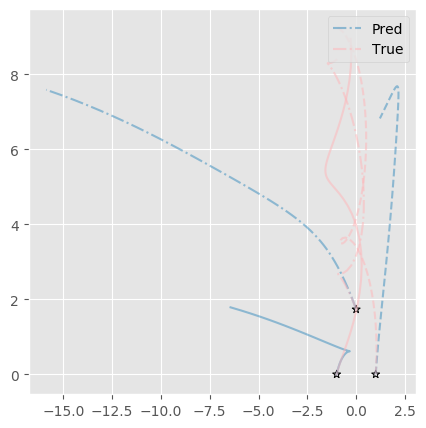

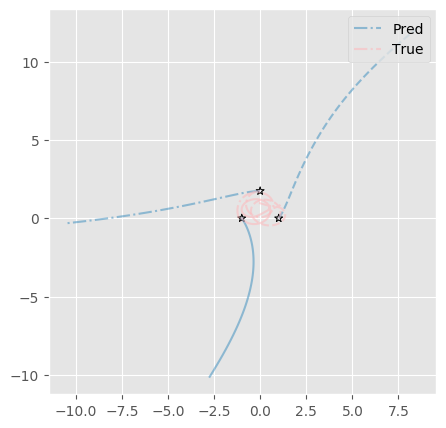

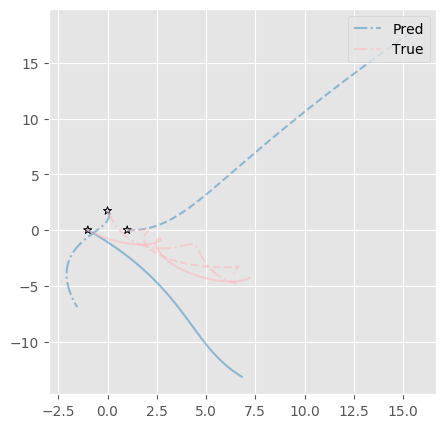

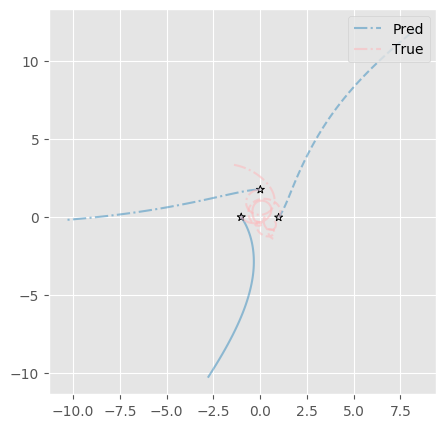

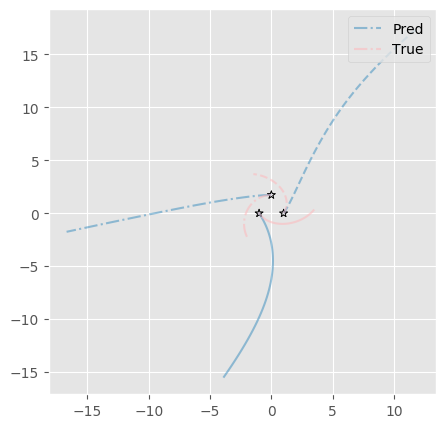

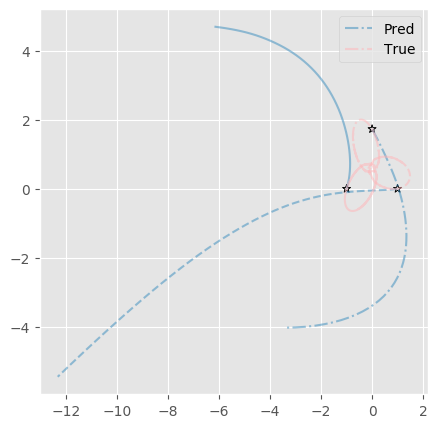

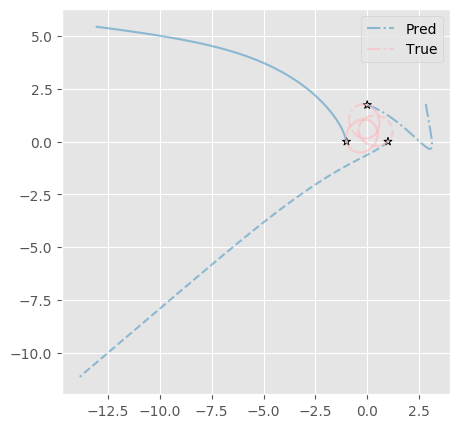

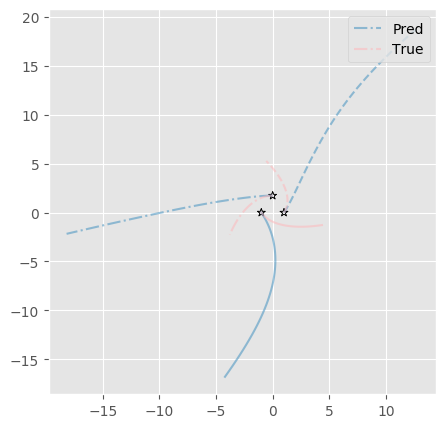

┌ Info: Main.Models.NeuralRelation{Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},DenseNet,Float32,Array{Float32,1}}(Dense(4, 50), DenseNet(Chain(Dense(100, 100), #30, Dense(100, 100), #30, Dense(100, 2))), 0.1f0, Float32[0.1])
└ @ Main In[308]:66


In [308]:
include(srcdir("Models.jl"))
import .Models
Zygote.refresh()

function predict(m::Models.DeepTransition, env, T)
    function envfrom(state)
        dim = div(size(state, 1), 2)
        return Space(Particle.(fill(5e10, 3), state[1:dim], state[dim+1:end]))
    end
    state = Vector{Float32}(vec(stateof(env)))
    traj = [envfrom(state)]
    for t in 1:T
        state = Models.transit(m, state)
        push!(traj, envfrom(state))
    end
    return traj
end

function predict(m, env, T; d=2, n=3)
    function envfrom(state)
        return Space(Particle.(fill(5e10, n), [state[1:d,i] for i in 1:n], [state[d+1:2d,i] for i in 1:n]))
    end
    s = stateof(env)
    state = Matrix{Float32}(cat([vec(s[d*i-1:d*i,:]) for i in 1:n]...; dims=2))
    traj = [envfrom(state)]
    for t in 1:T
        state = Models.transit(m, state)
        push!(traj, envfrom(state))
    end
    return traj
end

function plot_traj!(ax, traj, is_ref=false)
    local handler
    c = is_ref ? COLORS[:pink] : COLORS[:blue]
    ps = positionof.(traj)
    Q = hcat(ps...)
    for (i, ls) in zip(1:div(size(Q, 1), 2), ["-", "--", "-."])
        handler = plot!(
            ax, TwoDimPath(Q[2i-1,:], Q[2i,:]), ls; 
            c=c, alpha=0.5, first=(color="black", marker="*")
        )
    end
    return handler
end

function vis(m, trajs, T_ext::Int=0)
    info = Dict()
    for (i, traj) in enumerate(trajs)
        traj_pred = predict(m, first(traj), length(traj) + T_ext - 1)
        
        fig, ax = figure(figsize=(5, 5))
        h1, = plot_traj!(ax, traj_pred)
        h2, = plot_traj!(ax, traj, true)
        ax.legend([h1, h2], ["Pred", "True"], loc="upper right")
        
        info[Symbol("trajs[$i]")] = fig
    end
    return info
end

# model = Models.DeepTransition((100, 100, 100), args.σ_obs)
# model = Models.NeuralForce((100, 100, 100), args.dt, args.σ_obs)
# model = Models.NeuralBodyForce(50, (100, 100), args.dt, args.σ_obs)
model = Models.NeuralRelation(50, (100, 100), args.dt, args.σ_obs)
@info model

using Test

function test_estforce(model)
    x1 = rand(2 * 2, 1, 5)
    x2 = rand(2 * 2, 1, 5)
    x3 = x1
    x = cat(x1, x2, x3; dims=2)
    f = Models.estforce(model, x)
    @test f[:,1,:] == f[:,3,:]
end

let model=model, batch=data.train[:,1:10]
    test_estforce(model)
#     @code_warntype model(batch...)
    model(batch...) |> display
    gradient(params(model)) do
        model(batch...).loss
    end
    
    info = vis(model, data_raw.trajs_test[1:5:end])
    for fig in values(info)
        display(fig)
    end
end

;

In [309]:
logger = WBLogger(project=projectname(), notes="")
config!(logger, args)


wandb: Waiting for W&B process to finish, PID 5648
wandb: Program ended successfully.
wandb: Run summary:
wandb:                 _step 2540
wandb:            _timestamp 1583871795.103394
wandb:   train/loglikelihood 3.5111567974090576
wandb:            train/loss -3.5111567974090576
wandb:              _runtime 147273.89364027977
wandb:            valid/loss -3.0075230598449707
wandb:   valid/loglikelihood 3.0075230598449707
wandb: Syncing 8 W&B file(s) and 488 media file(s)
wandb:                                                                                
wandb: Synced summer-elevator-113: https://app.wandb.ai/xukai92/BNP2/runs/ddgguwj0
wandb: Tracking run with wandb version 0.8.29
wandb: Run data is saved locally in wandb/run-20200310_203902-oxf3k4sq
wandb: Syncing run feasible-eon-16
wandb: ⭐️ View project at https://app.wandb.ai/xukai92/BNP2
wandb: 🚀 View run at https://app.wandb.ai/xukai92/BNP2/runs/oxf3k4sq
wandb: Run `wandb off` to turn off syncing.



In [313]:
let model=model, ps=params(model), n_epochs=200, opt=Optimise.ADAM(5f-4), batch_size=10
    with(logger) do
        @showprogress for epoch in 1:n_epochs
            train_shuffled = shuffle(data.train)
            for (iter, batch) in enumerate(eachbatch(values(train_shuffled); size=batch_size))
                local info
                gs = gradient(ps) do
                    info = model(batch...)
                    info.loss
                end
                @info "train" info...
                Optimise.update!(opt, ps, gs)
            end
            @info "valid" model(data.test...)... vis(model, data_raw.trajs_test[1:5:end])...
        end
    end
    
    bson(datadir("$(split(string(typeof(model).name), ".")[end]).bson"), model=model)
end

;

Progress: 100%|█████████████████████████████████████████| Time: 0:11:55


In [314]:
let model=model, traj_true=data_raw.trajs_test[11], T=length(traj_true)-1, T_ext=20
    traj = predict(model, first(traj_true), T + T_ext)
    HTML(animof(traj).to_html5_video()) |> display
    traj_combined = [Space([objectsof(traj[t])..., objectsof(traj_true[t])...]) for t in 1:T+1]
    HTML(animof(traj_combined; refs=[4, 5, 6]).to_html5_video()) |> display
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACXyG1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAS6WWI\nhAA3//728P4FNjuY0JcRzeidMx+/Fbi6NDe9zgAAAwAAAwAO4+Whwb68chzQAABbAAZ0gLRafOEN\nyA4QD1TuC/vctjBtZf0RW8e/4UfLpGw/4KZsC88+BpEGxGF08qOyfW2XA+Nmyg70JV/blF+DxkOJ\ng/w8ajQhcaQMn4qEjC9ab3n2lIpxyUbwjWiWzV4lMBdXdTR7SL69WaXE+JyUIqwtQZz6eHw3sH3d\nZsAO40Iork+tBsBAPO4caoe8G5KUK4DOffNeQ3cMjlGjDfqC0cm+4g4igJVMdwAFfMyAL3+bmzQP\nu7E05YKYbogyCMyS0euLGL3P3pViYTpGH7T1h2KKZWw38REUPSUWtnZIvrm2SQwxy7ABVQ/1h3zv\nAox+c9LNSj0bZp1X6a66cHzlECZ5KTsNz2BBv92bhaqGmqLAxHSenKeuA0eXhFkpibjdIBKP+dXm\nvVpR6ywW3nYUrapouuz/JvudcwVLTkIhmsBTQjmzJZpXP+JLv/7w4u7ZvBUYBFu297CAzmqNEfnl\nYkc+M8aYEMFzEzjcW/HgNZb/7VYiPfgEO1m9Pn0410C+CwI3yFJ3/M8q1I9wL5j6U/nxFm2fhOvn\nahbyDLgBoXJXwDfWZt4OD9TQcYkXTNVB0F+Rlvn8tpTNsSRI+15yoMf3mJ4b3klrHQmgBxcVZUmq\nM3likq3YkS59FoUScnHhFPfoKWsu/QA6C2AmDFAVvvug4SXP8i1gRxJYeJkZTOpK+az3KAOi1t6c\nCyW3by4F4YSFFHm7ilN9RpwEuw0fkWz9GgWbLmGL+NZZ1JtlFgGn2TE+FUUrao44synD7fzAKhGh\nQmVRhdozV90hew0x1UKODFejcRDU9yhAcHt0UtE7SKbOQm+cCsqnLgpYmELXdrHleqetTkR6o7ig\nANhCUyCjlTJugy3yUgocoRXS8aKKBVvvMPpaD8Koy4PXhSivQAxz5Q4Uz+6fPgdcm06/SsTgLJTe\nszD2hEI4+GhlAFa2KGtO7LosLC0PTELCzVeWaj91uQMuF5QcLD2zKgL0LK6t+QT5OUJi9ZtdaWoN\np4fXzM/keCxXO8RnVk8ndql9vVJ26Sb2qfT5hCCuLNPbX9IQAOVJWxBHjMpPBDpQQU6iiickTgd3\nNRylAIp4rLpbT8R+GsawDZCWb7X5wc1K/hKIvKefF+7+9WKmaNtaw189CQr9JK+uIrefCH/uDQf4\nccq9oOH+2IwDaIBnvxKVJ6nt6Mj9wzpwCuJWqvDTqLDG/YFdeDhDIH7+nT7uaRxZeZ8knhfeD6nh\nCIPN8+IVnIMwtSfDpigIwZgFRfQqYp7CHEbfegFpngn0MxCqZxuK2w+ElRUhp2581SaBZBQybOfj\nmMQIkMv/NlWh0O/t/1WDruDuYooVxtiDulwUdTTIA3DzCIQ5Od0SGQQVA7HqTwFgeqGBXen0xKmi\nktwB83+/1MelF3O8YQ767w2QdWqAAOmlX+F+Fean2bip/BfR/dAiUBsC+0Kq1hjQFeevMwRk+tk1\nFH0jEJjM4XS53qKKn+P0qTB7WrAOA3wOdEICbfSQUCoXalCrnFfkMFCSyGaCo3iuIpsFBOtKd1U7\nLJz18XQeutL3c3e4vqQjmAHn2BAX/gAAxsFBaL5u3D07bB1bDtxFEoHFUrW8JJNbAtL18cn2HkRv\noPxUZLyePl4+IwxNAky0tduqDOK3PFUVbE7bJAh1jopcJMkiTcHAETc2U6wSBDfBxoWMLHAkIVPC\nr9/74VXtS4zmFw+7bXqMAFj83BHaRnHjpXrz0eq46V5jCNF6ePAvAp0iyyo2y3ptQVI0V74cfLJ6\nDYJtVpt6BY4E4KBY5va+ULh5ojxsUd60xW0cm7tLOdPMjP7FSuhQel3/IBaLdglfT8xoNjGJ0Rbo\n5Xan1cjl8KCjJbIvDtIY57jWdX3kg4jdNiB0STZJBCeJgsZl0VbA6AX76kKEsq/RKwfoH0tlsLVP\n37lXMldGslJzI7Pl14i6M+pFAAAksvdmdkpYD3/2u66gr1e5UaqfQt9xrQrFcypIjhQWxDjLFnO/\njBQatlmKXE0+2VoejdwTYjvCmh6e4jT698SqF0cUo+tTVu0PmkfTbTuOlFdHpR1utuD2XO0sIwsB\nlcUgYxzHuihFpk0fD+i1nCqqKh20ZsRgj/VDkqbNALGj+li7voMSdMylnl53mbLuwZEhjKKgfQd5\nn5vBYTOvBxxXy5J+1QaazgJFvYvf2FI7MFYwdLmGCksnSWIhIrPoN9UOr2tloBN8bu6+dGLwX1dk\nbxIVsb6MKLEe/29MS2Iiq9ffwjWGs9dOh2zL9YUNibb7u7pcGq1RaWTWlc91nQImHlPCad2Eo2jm\nkBWEuo3IsR9W9LFCPMz4wJ9EnkPtqnDQcV+aTkhe++VJie9iQx2sAt2ay95K1c9rvdluZcm2HCx9\nTqBOGAOpksf8R9mzyel9udzgjmpZAS32VBQPknt6VYR1nPM6stPpWZxiFntYC+63ZZDsyN4rH4BL\nrKQYuH1MqmSFRbxBuT9V7reSmsqQv16Sf9vVjFiOizFAXJ0QlwviwnAECNMZ/KgUzbbk0x9B+clM\n9OAPwphCW3uZfMMuEaumFMOZz8C/1pbiGlM9iQItQ46P1He4eZ8bQHlUP3rpQpA+lyXc+Ta4MYFJ\n0pwK8k/pzRgg4Sh6SZIT7bACf2iQDZ27Ro5AeVohPfBJmDGkRLTFjM0VVJ0KHqoFTQKpT0HcCf+u\nnq/UtJsao58nyXvNviaElZvj+l1wsr2TG15ziAAkLFS9f8

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABV9G1kYXQAAAKvBgX//6vcRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQyIHIyNDk1IDZhMzAxYjYgLSBILjI2NC9NUEVHLTQg\nQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE0IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv\neDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9\nMHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm\nPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6\nb25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NDggbG9v\na2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh\nY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly\nYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3\nZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTIwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl\nc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg\ncXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALO2WI\nhAA7//73Tr8Cm0WXagOSVwr2yqQmWblSawHypgAAAwAAAwAEyF+F1hnJSk2EAAAd4AHePH5wiR/A\nJyE/bVwR9qpjBF6KNMUYvGfyMlw7TLCitYLpdtqb5MIyX9dOqLcIwmW0r+fLkeNhsExFlasKt77E\nZkW2zz+0msGO1BrEEFaLxIOh203uZOP9XTepyndMkgT7oJ75g9hbOZ6rF4d1+gONInjlz6IJMMYY\nwAtw+xuAeA8JU8wcBlxTPNTRUlf7ZnG3D6VkeNdv8BJVblaVPBnB6X1YVu/Lo/DlOBURu0P+zr03\nBnNyF9dtXTT+NDfo+b6URwqfShch95NtUALZJoA3kTdndkB39W+VHkUG8X/4synOpBk+9OM0azvN\nrXBvEpnwkvymCrpSzBcTmqC2lAqwdowmRBGGzdvIbEYgGQgv3nQyOF02TASWpxnf8PZRsQmH7MN6\nEspYdJUU9b7VbsShiFSTLSy1WPichyr/U2Mz3PBoj7hwpqEB2vXhmb3Is/Om06M8CABOlxseRFVw\nyV0UfljEr+PrXkvRxw1xLk5+mrGuslY3+xHegbXG3XTNRLzrXWuEjG13GdEieZH4YhTnrkgP0A+g\nnq0uRXQwPuoJcOQAUmCAKeAAF6wCtYIleCzN+T5qBMw/owHXNxfkzKq3g4ePoqiDFotplCuucg7y\nXTABLbBfsovk3LcurEdK2bNPn74pqi7+tyBpVqGrvxcoIDKs3urZiYo0V1IrNVHUNhy7uvFLK5i3\n1H6CPPQT4YBESnxuOSrp6HsLXJXagMXXDQtsFN7OjZoX5peCd1tgHnlniYGr0WTN/3V/+U9Z8MsV\ni3BqPGAFKSsKi2GQhZ2u7jyMLQxfPwLYu/IN7X5iC+ufLItz4YIploqRq8sOHGXoLu8SSdtNByyQ\nX/5UaFWJbG2YbyzfXzfj0OZ0V7nNv4/V3tgyk4iqQaMvU6uY5giIs0XhYgc+hEtDnW61zKc+3vFv\n9oGij9bHMgFwWuYlKkkeoDRIovc+JqQsOYEZVKQ5PBl536alNPJdYhPBGbRPdBXuYSKHuCRFvlH1\nR6q9qN1KSPEhsJhyM9Kz7ve4dlbojNV0BLmqqvOJjrXOKDn6ALM2bPtRiVxlULI07RECgAc/TI5j\nNKysKo6BcAKlu+RQ2DjGSgTu3K8oSvRfDQ5IvP/RwzmF3EvJxV3IsMO9M7L6YZHQX8BJuhATvcNk\ndunbuC9LhaF5z4XW9JZm2uvW7uVjcu6nq37a5asGe7Dwc+gHrSthuA04G+5KBzaJX6lKQsBwu/96\nyM0C3r6rRPVa0CIk3dFkOYWoEKseAlMKB+fjaeOvYwGcA/PZ9/+o8Pq6BK7N9/3keZ3y8OQ7sSwb\nuIrVhw+1zNxvS4dzQGxZdT9Gf6hA5dYUbtxlJhqy2wb0ixEI51omPEaAg9QhBaw8HDe6+k19YBe4\nxhwWG6sBHE3R9ARM9zEp7tFK4EwDCNyOMFtlVVbQzKFwKeZBgOBcwoL5fsmQ7dYWc8EXt/sIOkfb\n05WlPbNvH/5wXhgt7N9hW/ENHsxx8M2S8uDlXDDx6tz8vtDNMZ9A8a/IbQbGfMDHBxsx4weH1IkD\nHbJQ0TYGvzZ3ZuOq4hyqHmG8+VL/oczmzWXx5Ful7kIIUNgusv+MVfNDOYDTaoDdmEOvdjxd19ve\n5U5jX/t/JFAvDmJJ6xpADBfEpJCTte24scBedp5u2CmwhpeyMd+1ng6SWlohtax56+wfRaa5MmT0\nn4w5AUiKbMEDGh8xfHHs7TlWcxASHiN5Qv4zVc9GEKlP/UK4n5l8sSCcoBB5oVqQg/Vz3ZuUoXIx\nc3QGV9cblrUyx1shCui4GTEA5pwVg1MVH6c6OfqmGMgAE5HpuTWYBMXK02Z2e44y9gj4J2Xn4cFv\n/pK2hc6Zl04WszMu/tlz/0K662yiH0PKU7JGVwf8kfHllPQeDZacW+lVphE2/M3IhaiJYmbhSObk\njf59029lSCaAkZGTSs3GqMyXHQIgeLydCXDAAVMfVRt+yKojSmDIe9zY6CZC87+3GisI1eIJuek/\nXuVQ62Djfy3FuQtk2sb0YQf50gTtjZkaGWI1TfWQP1x4RdENmZMXcPOmmR8yBpbDlkaFqeXA92r5\nNI2RCitU4Cg0hml317a7STqai/0jj3phKBnJlBwD/Bj7FAhWw/Pb5e+dIodv/mXkQw8plP+1YEHC\niEOMvUSpNViqE68PnGeN4X+Q+pmrle+lE6IuGs4F3dBJdnoPEVEdq5WKpVqZQrj5L2tJq/P380nx\nTdG1yBHbSFcJXWW1d7a8ybjyicdMlq+TNh3W9OFxoliLw2NVis8HxUaaMQwCU1rTFRp6r6DE82Jj\nHE74252TT2xpT27PCUfBXPkxSG44+7xkYoADioKsyzlCBFCUStLqlieRo5X5Mq0ZEs3GFl0U53Hv\nukTFIjDpZUVJPZCNcuUVCm0Y7al/wnH4cp/z49LsyN9PT5eBkmYUAiWL8cwjvIC09LswP5tdK+DI\nQObHZKZ9YYlMp/oRfb+GovZAo5gKhAoot9LmJEfT3LohIFALWDyTBLl8X2d6lDFPqVJipm/4JcBQ\nAjSbox9JuiicZt3ihLYNC9H1vVqtSXUKcRvPo3sx66nfgzRyKXqRljQ5biJbhrGOHyHjf8tKFCjX\nN6jgDMESJ/TL+d34+YknhNjiKTIOC/Vna001Be8ouiz+WvIvpNBnUVJ2TjeojmTItSgpCJe8+jrH\n0w1rpt1+zSgiLUzUR8PrWP7yQJRNf+AetN/7GjALkCTtS9

## MCMC

In [ ]:
@model three_body(ms, states, dt) = begin
    q ~ MvNormal(zeros(6), 10)
    p ~ MvNormal(zeros(6), 10)
    space = Space(Particle.(ms, q, p))
    for i in 1:length(states)
        space = transition(space, dt)
        states[i] ~ MvNormal(vec(stateof(space)), 1e-1)
    end
end

@time chn = sample(three_body(massof.(data.objs0), data.states, args.dt), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

bson(datadir("three_body-noise=$(args.σ).bson"), chn=chn)

;

let n_mc = 50, T = 100, do_mean = true, res = get(chn[end-n_mc+1:end], [:q, :p])
    Q = Matrix{Float64}(hcat(res.q...)')
    P = Matrix{Float64}(hcat(res.p...)')
    if do_mean
        Q = mean(Q; dims=2)
        P = mean(P; dims=2)
    end
    Q̂ = zeros(6, T)
    for i in 1:size(Q, 2)
        q, p = Q[:,i], P[:,i]
        space = Space(Particle.(data.ms, q, p))
        traj = simulate(space, args.dt, T)
        Q̂ = Q̂ + hcat(positionof.(traj)...)
    end
    Q̂ = Q̂ / size(Q, 2)
    HTML(animof(Q̂).to_html5_video()) |> display
end

;